In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

In [3]:
os.environ["TF_ENABLE_CUBLAS_TENSOR_OP_MATH_FP32"] = "1"
os.environ["TF_ENABLE_CUDNN_TENSOR_OP_MATH_FP32"] = "1"
os.environ["TF_ENABLE_CUDNN_RNN_TENSOR_OP_MATH_FP32"] = "1"
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = "1"
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_LOSS_SCALING"] = "1"

## Training Overview

#### DNN 

In [4]:
df_dnn1 = pd.read_csv('csv-train-logs/DNN_all-features.csv')
df_dnn2 = pd.read_csv('csv-train-logs/DNN_base-features.csv')
df_dnn3 = pd.read_csv('csv-train-logs/DNN_agg-features.csv')
df_dnn1['fitur'] = 'Gabungan'
df_dnn2['fitur'] = 'Utama'
df_dnn3['fitur'] = 'Agregasi'

In [5]:
df_training_dnn = pd.concat([df_dnn1, df_dnn2, df_dnn3])
df_training_dnn.reset_index(drop=True, inplace=True)

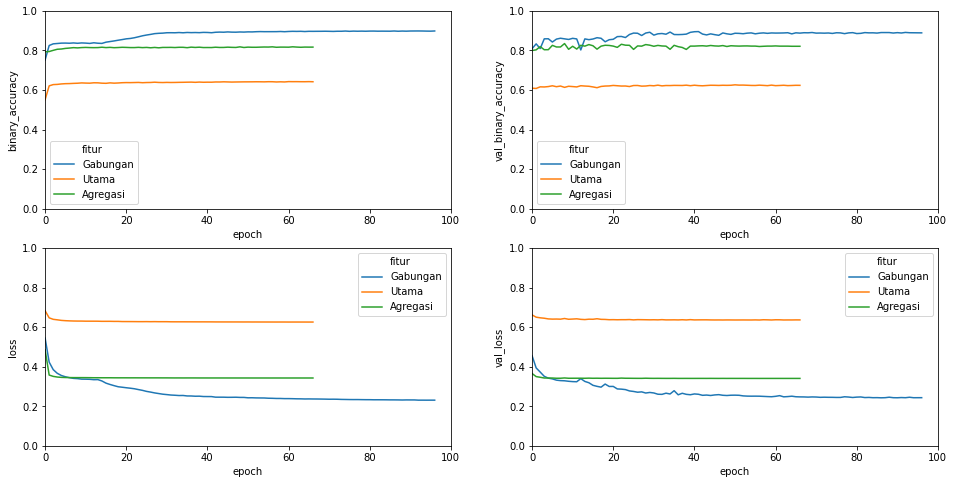

In [6]:
fig, axis = plt.subplots(2,2, figsize=(16,8))
for axs in axis:
    for ax in axs:
        ax.set_ylim(0,1)
        ax.set_xlim(0,100)
sns.lineplot(x='epoch', y='binary_accuracy', hue='fitur', data=df_training_dnn, ax=axis[0,0])
sns.lineplot(x='epoch', y='val_binary_accuracy', hue='fitur', data=df_training_dnn, ax=axis[0,1])
sns.lineplot(x='epoch', y='loss', hue='fitur', data=df_training_dnn, ax=axis[1,0])
sns.lineplot(x='epoch', y='val_loss', hue='fitur', data=df_training_dnn, ax=axis[1,1])

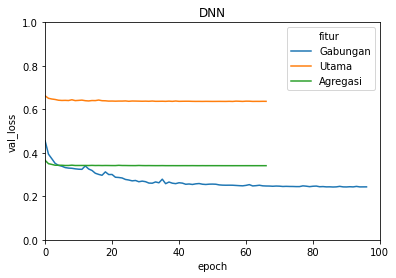

In [7]:
plt.ylim(0,1)
plt.xlim(0,100)
plt.title('DNN')
sns.lineplot(x='epoch', y='val_loss', hue='fitur', data=df_training_dnn)
plt.savefig('plots/DNN_training.png')

#### LSTM

In [8]:
df_lstm1 = pd.read_csv('csv-train-logs/LSTM_all-features.csv')
df_lstm2 = pd.read_csv('csv-train-logs/LSTM_base-features.csv')
df_lstm3 = pd.read_csv('csv-train-logs/LSTM_agg-features.csv')
df_lstm1['fitur'] = 'Gabungan'
df_lstm2['fitur'] = 'Utama'
df_lstm3['fitur'] = 'Agregasi'

In [9]:
df_training_lstm = pd.concat([df_lstm1, df_lstm2, df_lstm3])
df_training_lstm.reset_index(drop=True, inplace=True)

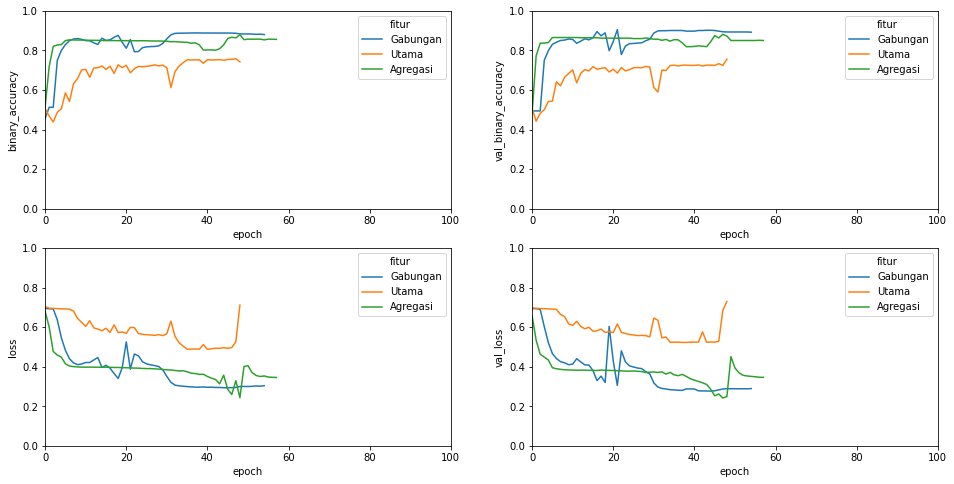

In [10]:
fig, axis = plt.subplots(2,2, figsize=(16,8))
for axs in axis:
    for ax in axs:
        ax.set_ylim(0,1)
        ax.set_xlim(0,100)
sns.lineplot(x='epoch', y='binary_accuracy', hue='fitur', data=df_training_lstm, ax=axis[0,0])
sns.lineplot(x='epoch', y='val_binary_accuracy', hue='fitur', data=df_training_lstm, ax=axis[0,1])
sns.lineplot(x='epoch', y='loss', hue='fitur', data=df_training_lstm, ax=axis[1,0])
sns.lineplot(x='epoch', y='val_loss', hue='fitur', data=df_training_lstm, ax=axis[1,1])

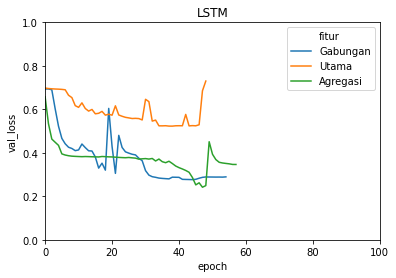

In [11]:
plt.ylim(0,1)
plt.xlim(0,100)
plt.title('LSTM')
sns.lineplot(x='epoch', y='val_loss', hue='fitur', data=df_training_lstm)
plt.savefig('plots/LSTM_training.png')

## Choose Model

In [12]:
df_training_dnn.loc[(df_training_dnn['val_loss'] == df_training_dnn.min()['val_loss'])]

,epoch,binary_accuracy,loss,val_binary_accuracy,val_loss,fitur
86,86,0.898438,0.232285,0.890559,0.242811,Gabungan


In [13]:
df_training_lstm.loc[(df_training_lstm['val_loss'] == df_training_lstm.min()['val_loss'])]

,epoch,binary_accuracy,loss,val_binary_accuracy,val_loss,fitur
151,47,0.863555,0.329484,0.881593,0.241785,Agregasi


## Model Testing

In [14]:
evaluations = []

In [15]:
dnn_model_path = "saved-models/DNN_all-features_ep-87_valos-0.2428.hdf5"
lstm_model_path = "saved-models/LSTM_agg-features_ep-48_valos-0.2418.hdf5"

#### DNN

In [16]:
dnn_model = tf.keras.models.load_model(dnn_model_path)

In [17]:
X_test_dnn = np.load('datasets/X_test_DNN_all-features.npy')
y_test_dnn = np.load('datasets/y_test_DNN_all-features.npy')

[[4935  718]
 [ 384 5270]]


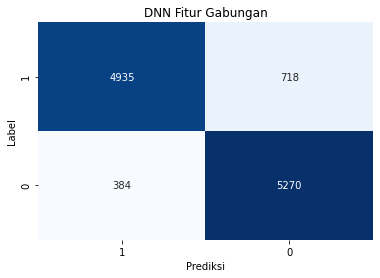

In [18]:
start_time = time.time()
y_pred = dnn_model.predict(X_test_dnn)
time_taken = (time.time() - start_time)/len(y_test_dnn) * 1000

y_pred_dnn = []
for pred in y_pred:
    if(pred >= 0.5):
        y_pred_dnn.append(1)
    else:
        y_pred_dnn.append(0)
y_pred_dnn = np.array(y_pred_dnn)

dnn_conf = tf.math.confusion_matrix(y_test_dnn, y_pred_dnn)

TP = dnn_conf.numpy()[0][0]
TN = dnn_conf.numpy()[1][1]
FP = dnn_conf.numpy()[1][0]
FN = dnn_conf.numpy()[0][1]

print(dnn_conf.numpy())

plt.title('DNN Fitur Gabungan')
sns.heatmap(dnn_conf.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0], cbar=False)
plt.ylabel('Label')
plt.xlabel('Prediksi')
plt.savefig('plots/DNN_conf_matrix.png')

accuracy = (TP+TN)/(TP+TN+FP+FN)
misclassification_rate = 1-accuracy
precision = TP/(TP+FP)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
f1score = 2 * ((precision*recall)/(precision+recall))

evaluations.append(['dnn all', accuracy, misclassification_rate, precision, recall, specificity, f1score, time_taken])

#### LSTM 

In [19]:
lstm_model = tf.keras.models.load_model(lstm_model_path)

In [20]:
X_test_lstm = np.load('datasets/X_test_LSTM_agg-features.npy')
y_test_lstm = np.load('datasets/y_test_LSTM_agg-features.npy')

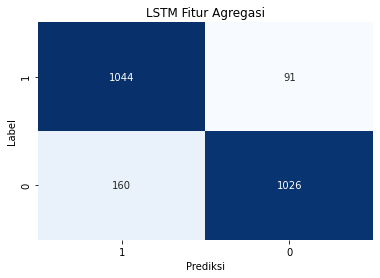

In [21]:
start_time = time.time()
y_pred = lstm_model.predict(X_test_lstm)
time_taken = (time.time() - start_time)/len(y_test_lstm) * 1000

y_pred_lstm = []
for pred in y_pred:
    if(pred >= 0.5):
        y_pred_lstm.append(1)
    else:
        y_pred_lstm.append(0)
y_pred_lstm = np.array(y_pred_lstm)

lstm_conf = tf.math.confusion_matrix(y_test_lstm, y_pred_lstm)

TP = lstm_conf.numpy()[0][0]
TN = lstm_conf.numpy()[1][1]
FP = lstm_conf.numpy()[1][0]
FN = lstm_conf.numpy()[0][1]

plt.title('LSTM Fitur Agregasi')
sns.heatmap(lstm_conf.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0], cbar=False)
plt.ylabel('Label')
plt.xlabel('Prediksi')
plt.savefig('plots/LSTM_conf_matrix.png')

accuracy = (TP+TN)/(TP+TN+FP+FN)
misclassification_rate = 1-accuracy
precision = TP/(TP+FP)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
f1score = 2 * ((precision*recall)/(precision+recall))

evaluations.append(['lstm agg', accuracy, misclassification_rate, precision, recall, specificity, f1score, time_taken])

In [22]:
df_evaluation = pd.DataFrame(evaluations, columns=['model','accuracy', 'misclassification_rate', 'precision', 'recall', 'specificity', 'f1score', 'time_taken'])

In [23]:
df_evaluation.head()

,model,accuracy,misclassification_rate,precision,recall,specificity,f1score,time_taken
0,dnn all,0.902538,0.097462,0.927806,0.872988,0.932083,0.899563,0.089510
1,lstm agg,0.891857,0.108143,0.867110,0.919824,0.865093,0.892689,1.077713


## Model Comparison

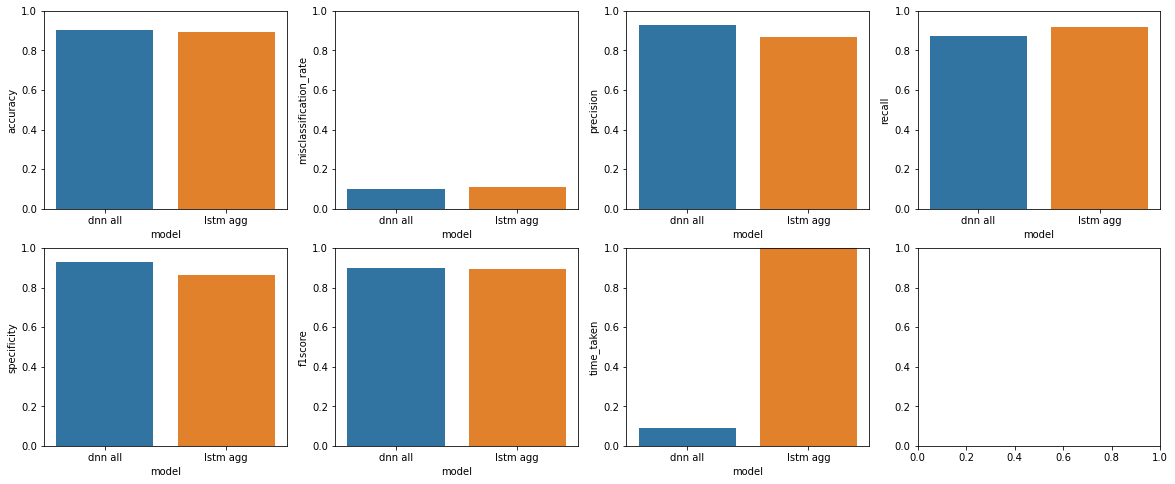

In [24]:
fig, axis = plt.subplots(2,4, figsize=(20,8))

for axs in axis:
    for ax in axs:
        ax.set_ylim(0,1)

sns.barplot(x='model', y='accuracy', data=df_evaluation, ax=axis[0,0])
sns.barplot(x='model', y='misclassification_rate', data=df_evaluation, ax=axis[0,1])
sns.barplot(x='model', y='precision', data=df_evaluation, ax=axis[0,2])
sns.barplot(x='model', y='recall', data=df_evaluation, ax=axis[0,3])
sns.barplot(x='model', y='specificity', data=df_evaluation, ax=axis[1,0])
sns.barplot(x='model', y='f1score', data=df_evaluation, ax=axis[1,1])
sns.barplot(x='model', y='time_taken', data=df_evaluation, ax=axis[1,2])

# Convert To TFLite

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_model)
tflite_model = converter.convert()
open(f"./tflite-models/{int(time.time())}_dnn_drowsy.tflite", "wb").write(tflite_model)

2452